# Kerékpárbérlés Előrejelzés

projekt célja a napi kerékpár bérlések számának előrejelzése egy városi bike-sharing rendszerben.  
Az adathalmaz tartalmazza az időjárási körülményeket, a naptári jellemzőket és a felhasználói viselkedést.  
A cél egy olyan regressziós modell felépítése, ami képes kezelni az időbeli mintázatokat és jól általánosít különböző évszakok között.
Az elemzés során baseline modelltől haladok a finomhangolt modell felé.

A teljes folyamat lépései:
- Adatmegismerés és feltáró elemzés (EDA)  
- Feature engineering (új jellemzők képzése, szinusz–koszinusz transzformációk)  
- Modellépítés `HistGradientBoostingRegressor` segítségével  
- Modellértékelés és interpretálhatóság SHAP elemzéssel
- Majd a modell tuningolása és optimalizálása

### Az adat megismerése
Az adathalmaz 2011–2012 közötti napi és órás kerékpárbérlési adatokat tartalmaz (Jelenleg most csak a naposat használom, de előkészítettem az órás adatokat, későbbi felhasználásra).  
Minden sor egy adott naphoz tartozó összesített bérlésszámot (`cnt`) reprezentálja, amit két részre bontottak: `casual` és `registered` felhasználók.  
Az időjárási adatok (hőmérséklet, páratartalom, szélsebesség) mellett naptári jellemzők (évszak, hónap, nap, munkanap) is megtalálhatók.

### Adatforrás
A projekt a [Bike Sharing Dataset (Kaggle)](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) adataira épül.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_consistent_length
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import shap

### SMAPE metrika
https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [ ]:
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    check_consistent_length(y_true, y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, eps)
    return np.mean(diff) * 100

In [5]:
plt.rcParams["figure.dpi"] = 120
RANDOM_STATE=42

In [6]:
df_daily =  pd.read_csv('./data/day.csv', index_col=0)
df_intraday = pd.read_csv('./data/hour.csv', index_col=0)

In [7]:
df_daily.head(3)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


In [8]:
df_daily.shape

(731, 15)

In [9]:
df_daily.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [10]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 1 to 731
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      731 non-null    object 
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.4+ KB


In [11]:
df_daily['dteday'] = pd.to_datetime(df_daily['dteday'])
df_intraday['dteday'] = pd.to_datetime(df_intraday['dteday'])

In [12]:
df_intraday.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [13]:
df_intraday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float

## Napi adatok elemzése (EDA)

### Szezonális trendek
- A napi bérlések száma erősen szezonális mintázatot mutat: tavasszal és nyáron folyamatosan emelkedik, míg ősszel és télen visszaesik.  
  (*Rented bikes over the first year* és *Rented bikes by season* grafikonok)
- A regisztrált felhasználók aránya jelentősen magasabb az alkalmi bérlőkéhez képest, azonban nyáron a nem regisztrált („casual”) bérlések aránya is megugrik.  
  (*Casual vs Registered users*)

### Időjárási hatások
- A hőmérséklet és a bérlések között erős pozitív korreláció figyelhető meg (*Temperature vs Rentals & Feature corr. with rentals*).  
- A páratartalom és a szélsebesség negatívan hat a bérlések számára (*Feature correlation with rentals*).  
- A téli hónapokban a bérlések száma jelentősen visszaesik, valószínűleg a hideg és veszélyes közlekedési körülmények miatt (*Rented bikes by season*).

### Naptári mintázatok
- Ünnepnapokon jellemzően kevesebben veszik igénybe a bérlési szolgáltatást, mivel sokan nem dolgoznak és kevesebbet közlekednek ezáltal. (*Rentals holiday and non-holiday*).  
- A nyári hónapokban és hétvégéken magasabb a kereslet, ami a szabadidős és a tursiták által való (ahogy láttuk a `Casual vs Registered users` grafikonon, hogy nyáron az alkalmai felhasználoik aránya megugrik) használathoz köthető.  

### Korrelációk és eloszlások
- A `registered` és a teljes `cnt` között közel lineáris kapcsolat figyelhető meg (*Registered users and rented bikes*).  
- A `cnt` eloszlása közel normális, enyhe jobbra ferdeséggel (*Distribution of rented bikes*).  
- A hőmérséklet (`temp`, `atemp`) erős pozitív korrelációban van a bérlésszámmal, ami várhatóan jó prediktor lesz ezáltal.  
- A `casual` és `registered` változók önmagukban is nagy korrelációt mutatnak a célváltozóval, de ezek közvetlen használata adat-szivárgást okozhat, ezért a modellezés során elhagyom őket.

 

### Összegzés
Az EDA alapján a bérlések száma elsősorban **szezonális**, **időjárási** és **felhasználói típusokhoz kapcsolódó** tényezőktől függ.  
A hőmérséklet és a szezon a legerősebb prediktorok, míg a páratartalom és a szélsebesség negatív hatású tényezők.


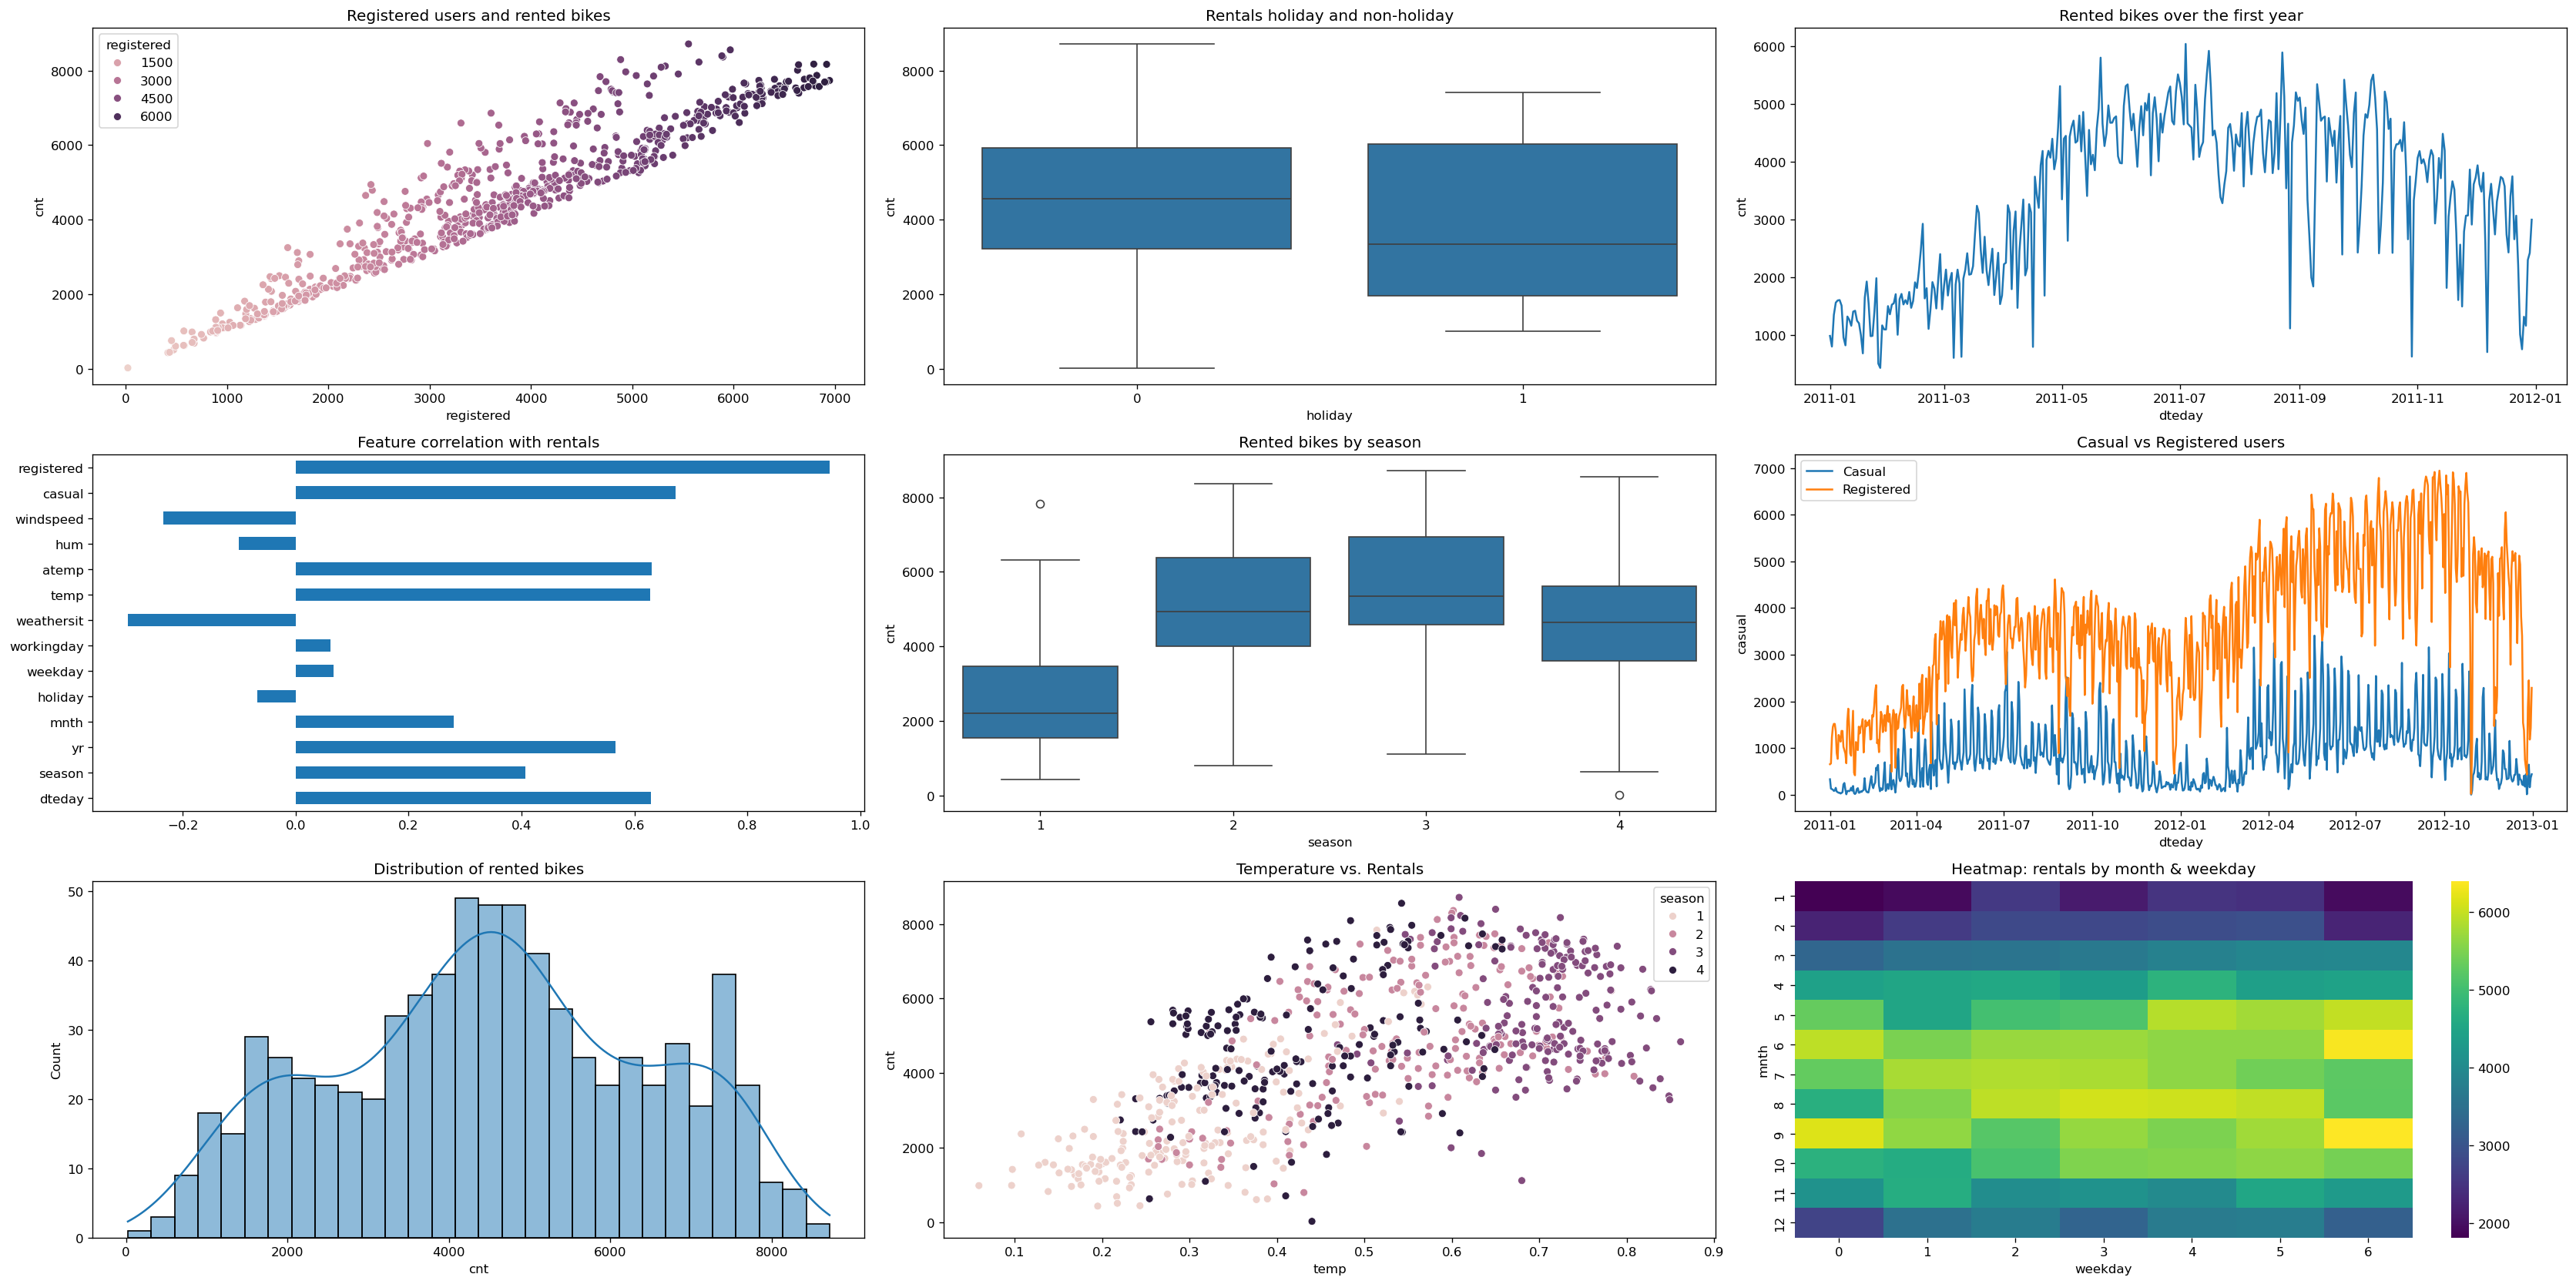

In [ ]:
f, ax = plt.subplots(3, 3, figsize=(28,14))



sns.scatterplot(data=df_daily, x='registered', y='cnt', hue='registered', ax=ax[0, 0])
ax[0, 0].set_title('Registered users and rented bikes')

sns.boxplot(data=df_daily, x='holiday', y='cnt', ax=ax[0,1])
ax[0, 1].set_title('Rentals holiday and non-holiday')
ax[1,0].set_xlabel('Holiday (0=No, 1=Yes)')

sns.lineplot(data=df_daily[0:364], x='dteday', y='cnt', ax=ax[0, 2])
ax[0, 2].set_title("Rented bikes over the first year")

corr = df_daily.corr()['cnt'].drop('cnt')
corr.plot(kind='barh', ax=ax[1,0])
ax[1,0].set_title('Feature correlation with rentals')


sns.boxplot(x='season', y='cnt', data=df_daily, ax=ax[1,1])
ax[1,1].set_title('Rented bikes by season')

sns.lineplot(data=df_daily, x='dteday', y='casual', ax=ax[1,2], label="Casual")
sns.lineplot(data=df_daily, x='dteday', y='registered', ax=ax[1,2], label="Registered")
ax[1, 2].set_title("Casual vs Registered users")
ax[1,2].legend()


sns.histplot(df_daily['cnt'], kde=True, bins=30, ax=ax[2,0]) # type: ignore
ax[2,0].set_title('Distribution of rented bikes')

sns.scatterplot(x='temp', y='cnt', hue='season', data=df_daily, ax=ax[2,1])
ax[2,1].set_title('Temperature vs. Rentals')


pivot = df_daily.pivot_table(values='cnt', index='mnth', columns='weekday', aggfunc='mean')
sns.heatmap(pivot, cmap='viridis', ax=ax[2,2])
ax[2,2].set_title('Heatmap: rentals by month & weekday')


plt.tight_layout()
plt.show()

## EDA – Óránkénti adatok (Intraday)

### Időbeli trendek
- Az óránkénti bérlési adatok erős szezonális mintázatot mutatnak, a tavaszi és nyári hónapokban jelentősen magasabb kereslettel.  
  (*Total rentals over time*, *Average rentals by month*.)
- A napi mintázatban két egyértelmű csúcs látható: reggel és késő délután, ami a munkába járás és a hazautazás időszakát tükrözi.  
  (*Rentals by weekday and hour*.)
- Az év második felében a bérlések száma fokozatosan emelkedik, ami a szolgáltatás elterjedését vagy a felhasználói bázis növekedését jelezheti.

### Felhasználói viselkedés
- A *Casual vs Registered rentals by hour* grafikon alapján két jól elkülönülő használati minta figyelhető meg:  
  - A **regisztrált** felhasználók főként a reggeli (8–9 óra) és délutáni (17–18 óra) csúcsidőben aktívak.  
  - Az **alkalmi** felhasználók inkább délután és hétvégén vesznek igénybe kerékpárt.  
- Ez arra utal, hogy a regisztrált felhasználók többsége munkába járási céllal használja a rendszert, míg az alkalmi felhasználók elsősorban szabadidős tevékenységhez kötik a bérlést.

### Szezonalitás és naptári hatások
- A *Seasonality Trends* boxplot egyértelműen mutatja, hogy a kereslet a tavasszal nő és nyári időszakban a tetőzik, míg ősszel csökken éstélen jelentősen alacsonyabb, mint a nyári csúcs.  
- A *Rentals on working vs non-working days* ábra megerősíti, hogy a munkanapokon átlagosan több bérlés történik, ami összhangban van a napi közlekedési mintázatokkal.

### Időjárási hatások
- A *Temperature vs Rentals*alapján a hőmérséklet növekedésével általában nő a bérlések száma, de a kapcsolat nem teljesen lineáris: közepes (kb. 0.6–0.7 közötti normalizált) tartományban a növekedés már ellaposodik.
- A *Humidity vs Rentals* gyenge negatív összefüggést mutat: a magas páratartalomhoz alacsonyabb bérlésszám társul.  
- Összességében a kellemes, száraz időjárás ösztönzi leginkább a kerékpárhasználatot, míg a túl hideg vagy párás, valszeg esős napok visszafogják a keresletet.

### Havi szezonalitás
- Az *Average rentals by month* grafikon alapján a bérlések száma június és szeptember között tetőzik,  
  míg januárban és februárban a legalacsonyabb.  
- Ez a mintázat megerősíti a hosszú távú szezonális trendet, amit a napi adatokban is láthattunk.

### Korrelációk
- A *Correlation heatmap* alapján a hőmérséklet (`temp`, `atemp`) erős pozitív kapcsolatban áll a bérlésszámmal (`cnt`).  
- Az időjárási tényezők (`hum`, `windspeed`) gyenge negatív korrelációt mutatnak.  
- Az órára, munkanapra és hét napjára vonatkozó jellemzők kevésbé korrelálnak közvetlenül a bérlésszámmal,  
  ami arra utal, hogy az időjárási és szezonalitási tényezők magyarázzák a változások nagy részét.

### Összegzés
Az óránkénti adatok elemzése rávilágít arra, hogy a bérlések dinamikáját elsősorban a **munkába járási szokások**,  
az **évszakok** és azzal erősen összefüggő **időjárási körülmények** alakítják.  
A rendszerhasználat két fő mintázat köré szerveződik: a **rendszeres, munkaidőhöz kötött használat** és a **szabadidős, alkalmi aktivitás**.  
Ezek a felismerések irányt mutatnak a későbbi feature engineering során, különösen a ciklikus időjellemzők és időjárási interakciók beépítése terén.


C:\Users\sascs\AppData\Local\Temp\ipykernel_19992\625421092.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\sascs\AppData\Local\Temp\ipykernel_19992\625421092.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mnth', y='cnt', data=monthly, palette='mako', ax=ax[2,1])


Text(0.5, 1.0, 'Correlation heatmap for all features')

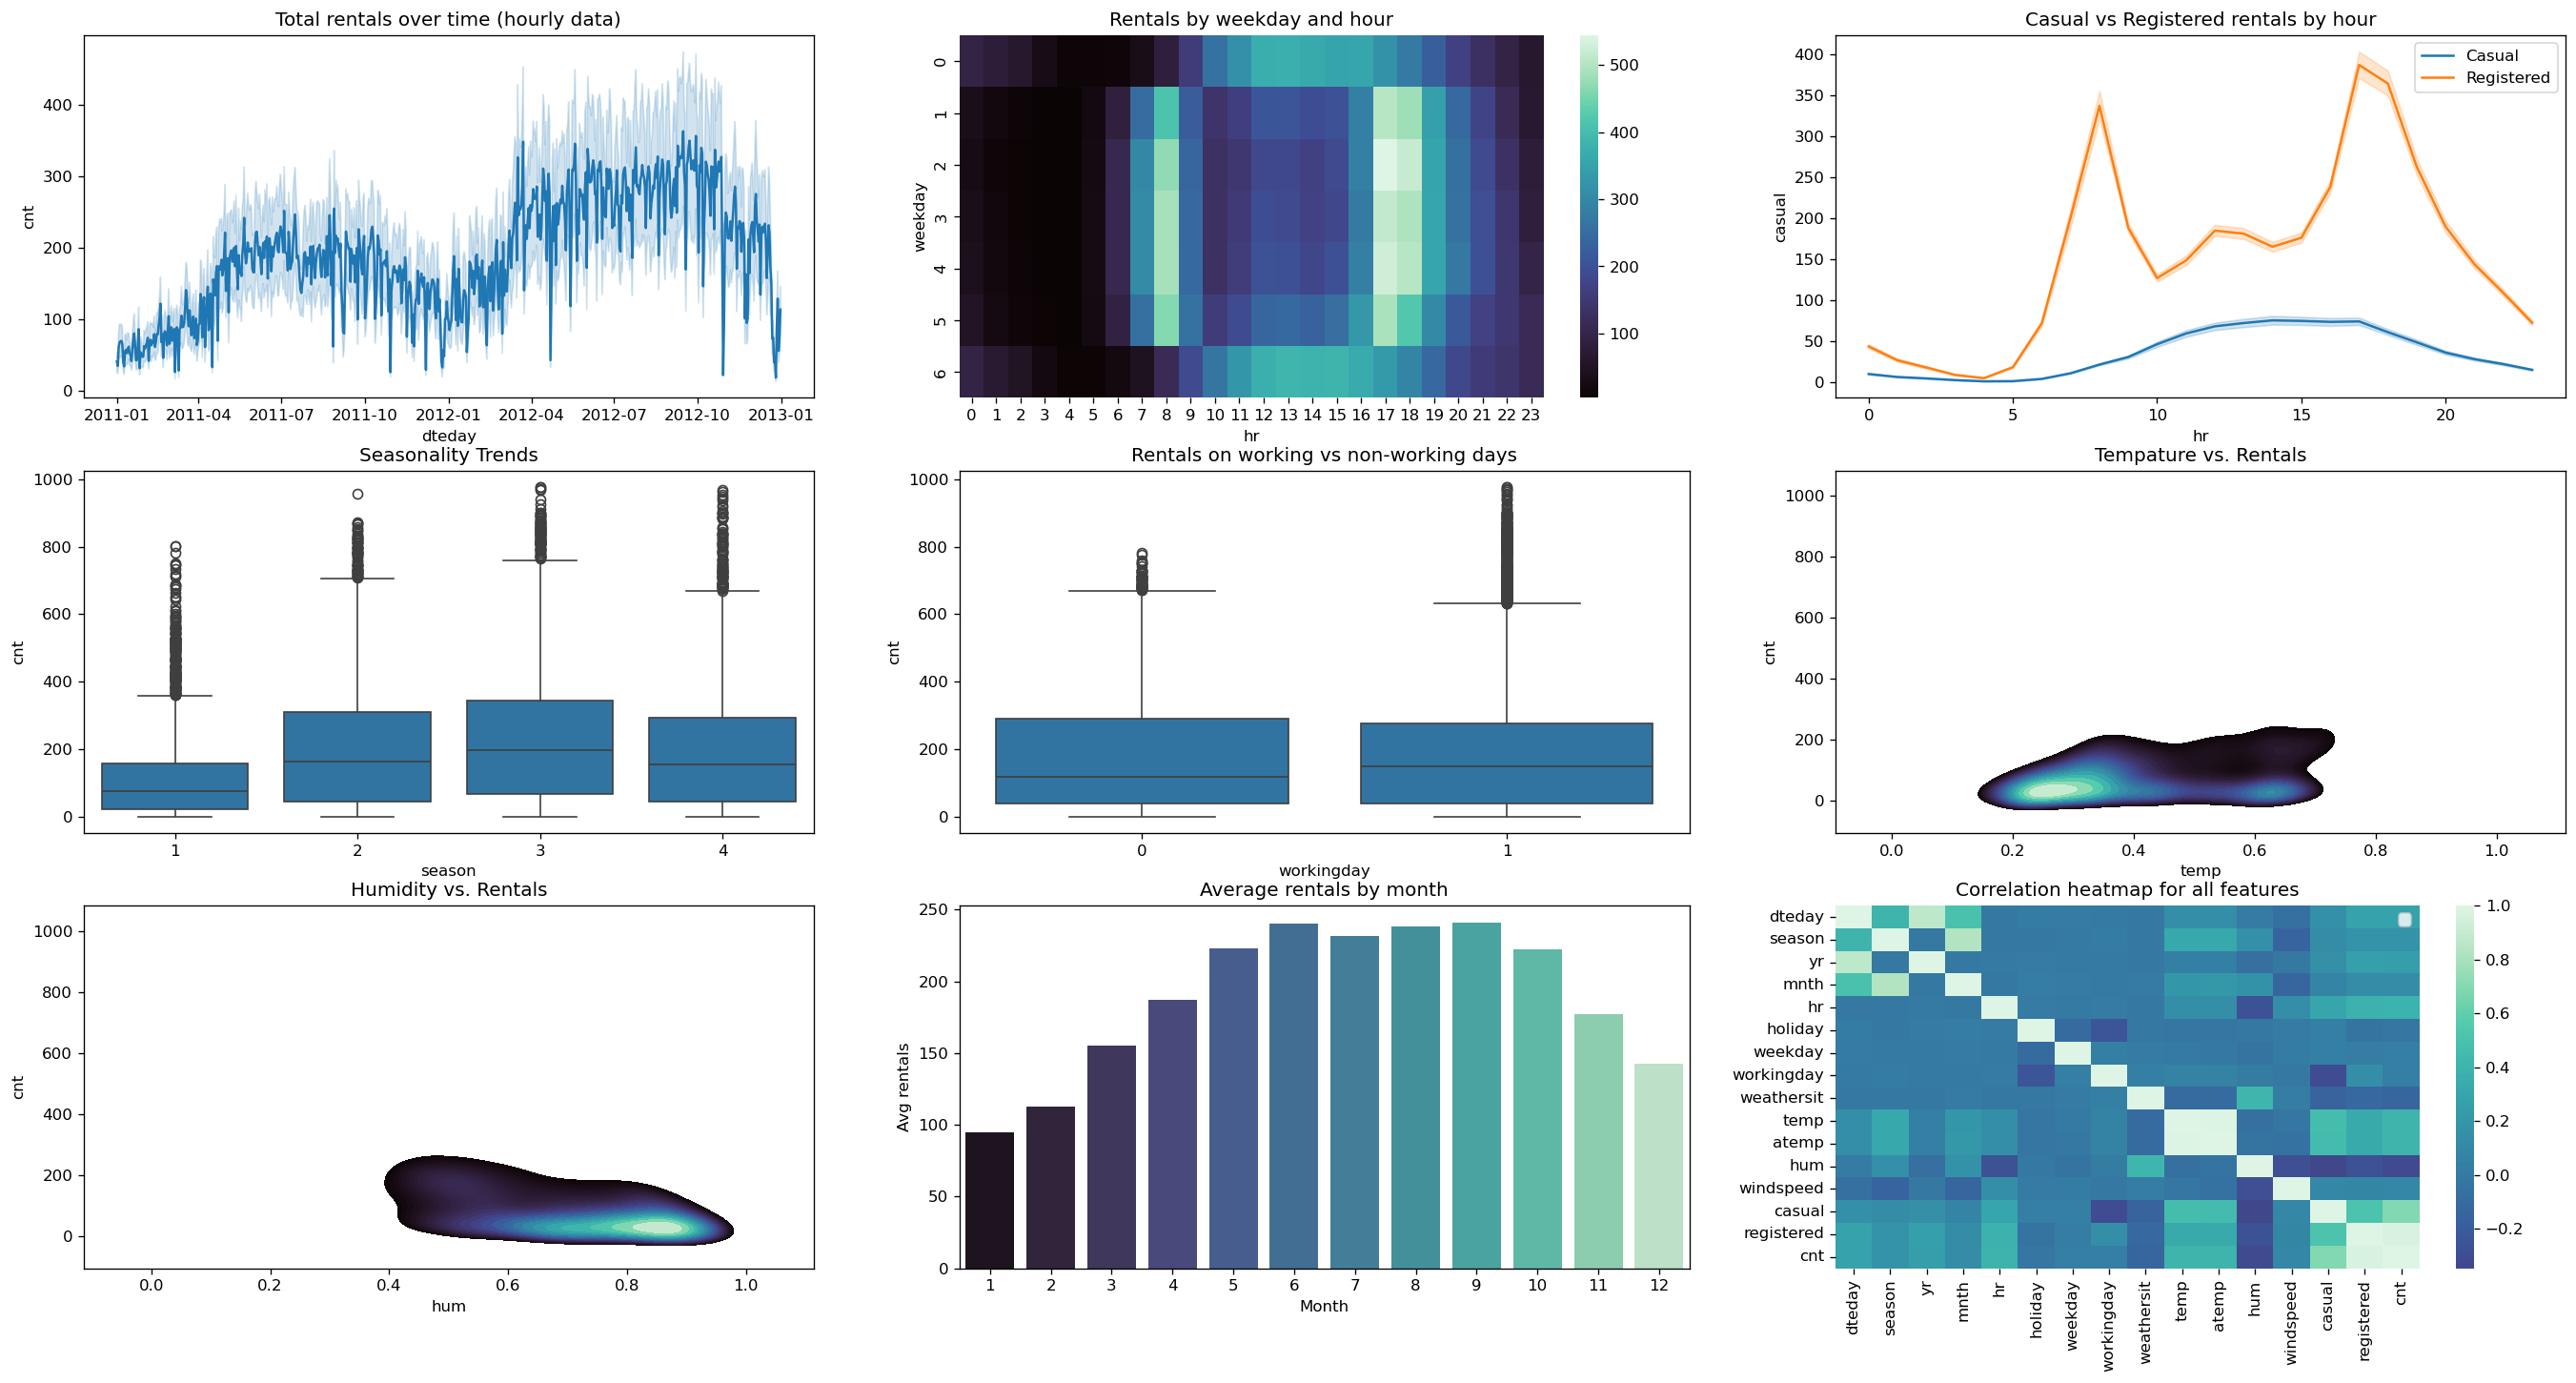

In [15]:
f, ax = plt.subplots(3, 3, figsize=(28,14))

sns.lineplot(x='dteday', y='cnt', data=df_intraday, ax=ax[0,0])
ax[0,0].set_title('Total rentals over time (hourly data)')


pivot = df_intraday.pivot_table(values='cnt', index='weekday', columns='hr', aggfunc='mean')
sns.heatmap(pivot, cmap='mako', ax=ax[0,1])
ax[0,1].set_title('Rentals by weekday and hour')


sns.lineplot(x='hr', y='casual', data=df_intraday, label='Casual', ax=ax[0,2])
sns.lineplot(x='hr', y='registered', data=df_intraday, label='Registered', ax=ax[0,2])
ax[0,2].set_title('Casual vs Registered rentals by hour')
plt.legend()


sns.boxplot(x='season', y='cnt', data=df_intraday, ax=ax[1,0])
ax[1,0].set_title("Seasonality Trends")


sns.boxplot(data=df_intraday, x='workingday', y='cnt', ax=ax[1,1])
ax[1,1].set_title("Rentals on working vs non-working days")

sns.kdeplot(df_intraday, x='temp', y='cnt', fill=1, thresh=.5, levels=30, cmap='mako', ax=ax[1,2])
ax[1,2].set_title("Tempature vs. Rentals")



sns.kdeplot(x='hum', y='cnt', data=df_intraday, fill=1, thresh=.5, levels=30, cmap='mako', ax=ax[2,0])
ax[2,0].set_title('Humidity vs. Rentals')

monthly = df_intraday.groupby('mnth')['cnt'].mean().reset_index()
sns.barplot(x='mnth', y='cnt', data=monthly, palette='mako', ax=ax[2,1])
ax[2,1].set_title('Average rentals by month')
ax[2,1].set_xlabel('Month')
ax[2,1].set_ylabel('Avg rentals')

sns.heatmap(df_intraday.corr(), cmap='mako', center=0, ax=ax[2,2])
ax[2,2].set_title('Correlation heatmap for all features')


## Feature Engineering

### Cél
A célom az volt, hogy olyan jellemzőket hozzak létre, amelyek jobban leírják a **szezonalitást** és az **időjárási hatásokat**, és segítenek a modellnek pontosabban tanulni.  
Fontos szempont volt, hogy minden átalakítás **Pipeline**-ban történjen, így a folyamat átlátható, reprodukálható és később is könnyen újratanítható legyen.

### Alap jellemzők és kizárások
A modellhez megtartottam a legfontosabb **numerikus** és **kategóriás** változókat:

- **Numerikus:** `temp`, `atemp`, `hum`, `windspeed`  
- **Kategóriás:** `season`, `yr`, `holiday`, `workingday`, `weathersit`

A `casual` és `registered` oszlopokat **nem** használtam, mert közvetlenül tartalmazzák a célváltozó (`cnt`) komponenseit, így **adat-szivárgást (data leakage)** okoznának.  
A `dteday` oszlopot is eltávolítottam, mert csak az időpontot jelzi; helyette a dátumból származtatott **ciklikus** és **derivált időjellemzőket** használom.

### Ciklikus kódolás
Az időalapú jellemzők (nap, hónap, szezon) **ciklikusan ismétlődnek**, ezért nem célszerű őket sima sorszámként kezelni.  
Például a „6. nap” és a „0. nap” egymás mellett vannak időben, mégis numerikusan messze esnének egymástól.

Ezt **sinus–cosinus** kódolással oldottam meg, ami segít a modellnek az ismétlődő mintázatok felismerésében.

**Példák:**
```python
weekday_sin = sin_wd
weekday_cos = cos_wd
month_sin = sin_mnth
month_cos = cos_mnth
hr_sin, hr_cos = hr_sin_hr, cos_hr
```

A `sin` és `cos` értékek folyamatosan írják le az időt, így a modell (a mostani `HistGradientBoostingRegressor`) könnyebben felismeri a periodikus viselkedést, nem egzakt pontokban gondolkodik, mint egy sima integer kódolás esetén.

**Forrás:**  
[Bansal, A., Balaji, K., & Lalani, Z. (2025). *Temporal Encoding Strategies for Energy Time Series Prediction.*](https://arxiv.org/pdf/2503.15456)

### Új jellemzők és interakciók
A baseline modellhez képest néhány **nemlineáris** és **időjárási interakciót** adtam hozzá, hogy a modell jobban kezelje a hőmérséklet–páratartalom–szélsebesség hatásokat.

| Kategória | Példa | Magyarázat | Miért jó? |
|------------|--------|-------------|-------------|
| **Nemlinearitás** | `temp_sq = temp**2`, `atemp_sq = atemp**2` | A hőmérséklet hatása nem lineáris, extrém hideg vagy meleg jobban befolyásolja a bérlést. | A négyzetre emeléssel adunk egy görbületet a változónak |
| **Interakciók** | `temp_hum = temp * hum`, `temp_wind = temp * windspeed` | Időjárási kombinációk (pl. meleg + szélcsend) hatása. | Ezzel a modell megtanulja a változók közti hatás-kölcsönhatást |
| **Komfortfok** | `comfort_diff = atemp - temp` | A „valós” és érzékelt hőmérséklet különbsége. | Kifejezi 1 változóban hogy mennyire más a felhasználó által érzett hőmérséklet a mérttől ezzel stabilabb együtthatót adva|
| **Szabadnap jelző** | `is_weekend = weekday.isin([5,6])` | Külön jelöli a hétvégi napokat, amikor más a kereslet. | Kezeli a hétvégevel bekövetkező napi eloszlás váltást |

Ezek a jellemzők segítenek a modellnek jobban megérteni a szezonális és emberi viselkedéshez köthető mintázatokat.

### Pipeline előnyei
Az összes átalakítást **Pipeline**-ban raktam össze, így minden transzformáció ugyanúgy lefut a tanító és teszt adatokon.  
A teljes folyamat reprodukálható, könnyen verziózható, és egy sorban futtatható a jellemzőképzés + modell tanítás + predikció.  
A kód emiatt sokkal átláthatóbb és egyszerűbben újrahasznosítható más projektekben is.

### Összegzés
A feature engineering után a modell jobban felismeri az **időbeli ismétlődéseket** és a **nemlineáris időjárási hatásokat**, miközben kevesebb, informatívabb jellemzőt használ.  
A ciklikus kódolás és a hőmérséklet-interakciók segítségével a modell stabilabb, és jobban leköveti a szezonális mintákat.  


In [ ]:
TARGET = 'cnt'
drop_cols = ['casual','registered','dteday']   # leakage veszély + dátum
cats_day  = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
cats_hour = cats_day + ['hr']

In [17]:
def fe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cols = ['temp','atemp','hum','windspeed','weekday','mnth']
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Hiányzó oszlop(ok) a FE-ben: {missing}")
    df['temp_sq'] = np.pow(df['temp'], 2)
    df['atemp_sq'] = np.pow(df['atemp'], 2)
    
    
    df['temp_hum'] = df['temp'] * df['hum']
    df['temp_wind'] = df['temp'] * df['windspeed']
    
    df['comfort_diff'] = df['atemp'] - df['temp']
    
    
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    
    if 'hr' in df.columns:
        df['sin_hr'] = np.sin(2 *  np.pi * df['hr'] / 24)
        df['cos_hr'] = np.cos(2 *  np.pi * df['hr'] / 24)
        
    
    df['sin_wd'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_wd'] = np.cos(2 * np.pi * df['weekday'] / 7)
    
    df['sin_mnth'] = np.sin(2 * np.pi * df['mnth'] / 12)
    df['cos_mnth'] = np.cos(2 * np.pi * df['mnth'] / 12)

    return df

In [68]:
# Daily PipeLine

X_day = df_daily.drop(columns=drop_cols+[TARGET]).copy()
y_day = df_daily[TARGET].copy()

pre = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown='ignore',sparse_output=False), cats_day)
    ], remainder='passthrough')


model = HistGradientBoostingRegressor(
    random_state=RANDOM_STATE,
        max_depth=6,
        min_samples_leaf=95,
        learning_rate=0.25,
        max_iter=5450
        )

pipe = Pipeline([
    ('fe', FunctionTransformer(fe, validate=False)),
    ("prep", pre),
    ("model", model)
])



In [69]:
split_day = '2012-10-01'

train = df_daily[df_daily['dteday'] < split_day]
test = df_daily[df_daily['dteday'] >= split_day]

X_train = train.drop(columns=['cnt', 'casual', 'registered', 'dteday'])
y_train = train['cnt']
X_test  = test.drop(columns=['cnt', 'casual', 'registered', 'dteday'])
y_test  = test['cnt']

In [70]:
pipe.fit(X_train, y_train)

,steps,"[('fe', ...), ('prep', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function fe ...002B2DC1D6020>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [71]:
y_pred = pipe.predict(X_test)

In [72]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
sMAPE = smape(y_test, y_pred)
# acc_score = accuracy_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"sMAPE:  {sMAPE:.2f}%")
print(f"R2:   {r2:.3f}")
# print(f"Accuracy:   {acc_score:.3f}")

RMSE: 1033.45
MAE:  786.99
sMAPE:  20.64%
R2:   0.710


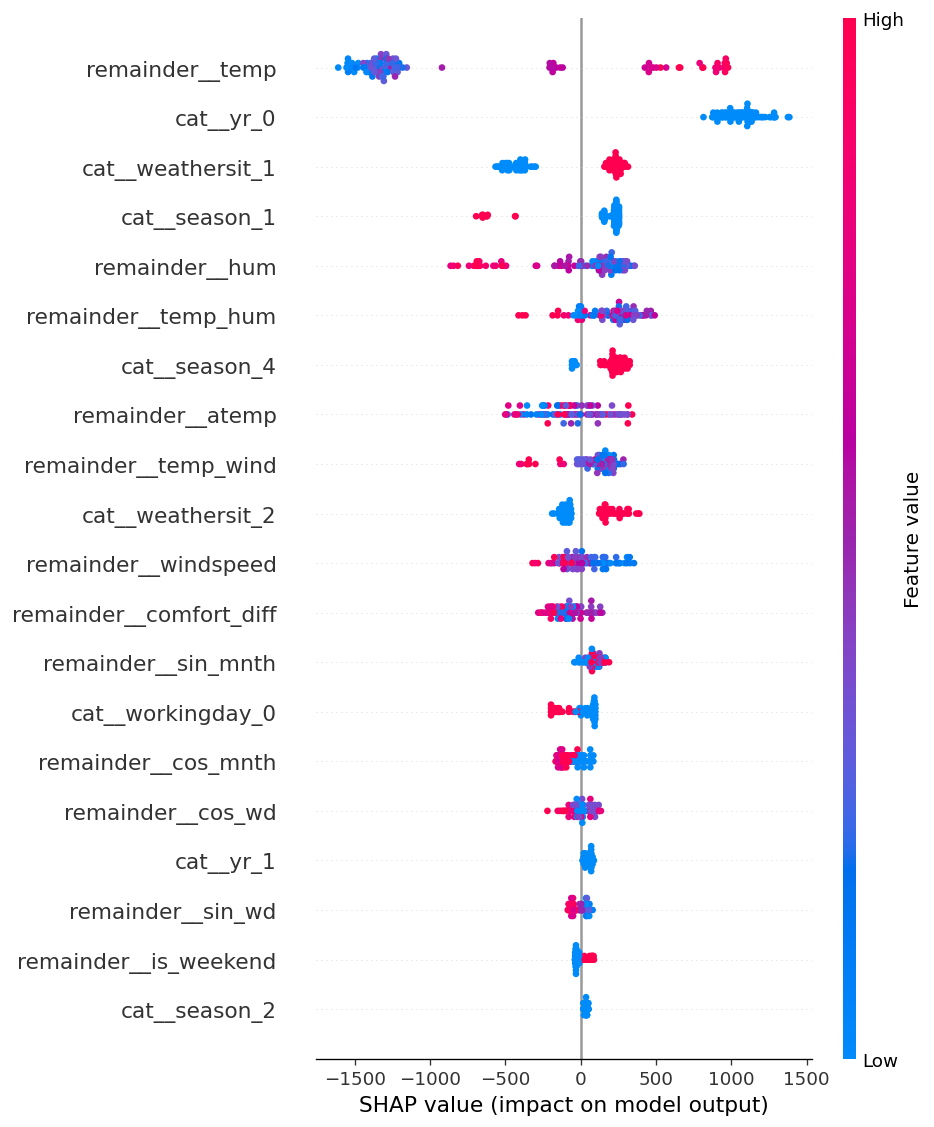

In [ ]:
model = pipe.named_steps['model']
X_fe = pipe.named_steps['fe'].transform(X_test.copy())
X_trans = pipe.named_steps['prep'].transform(X_fe)
feature_names = pipe.named_steps['prep'].get_feature_names_out()


explainer = shap.Explainer(model)
shap_values = explainer(X_trans)

shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


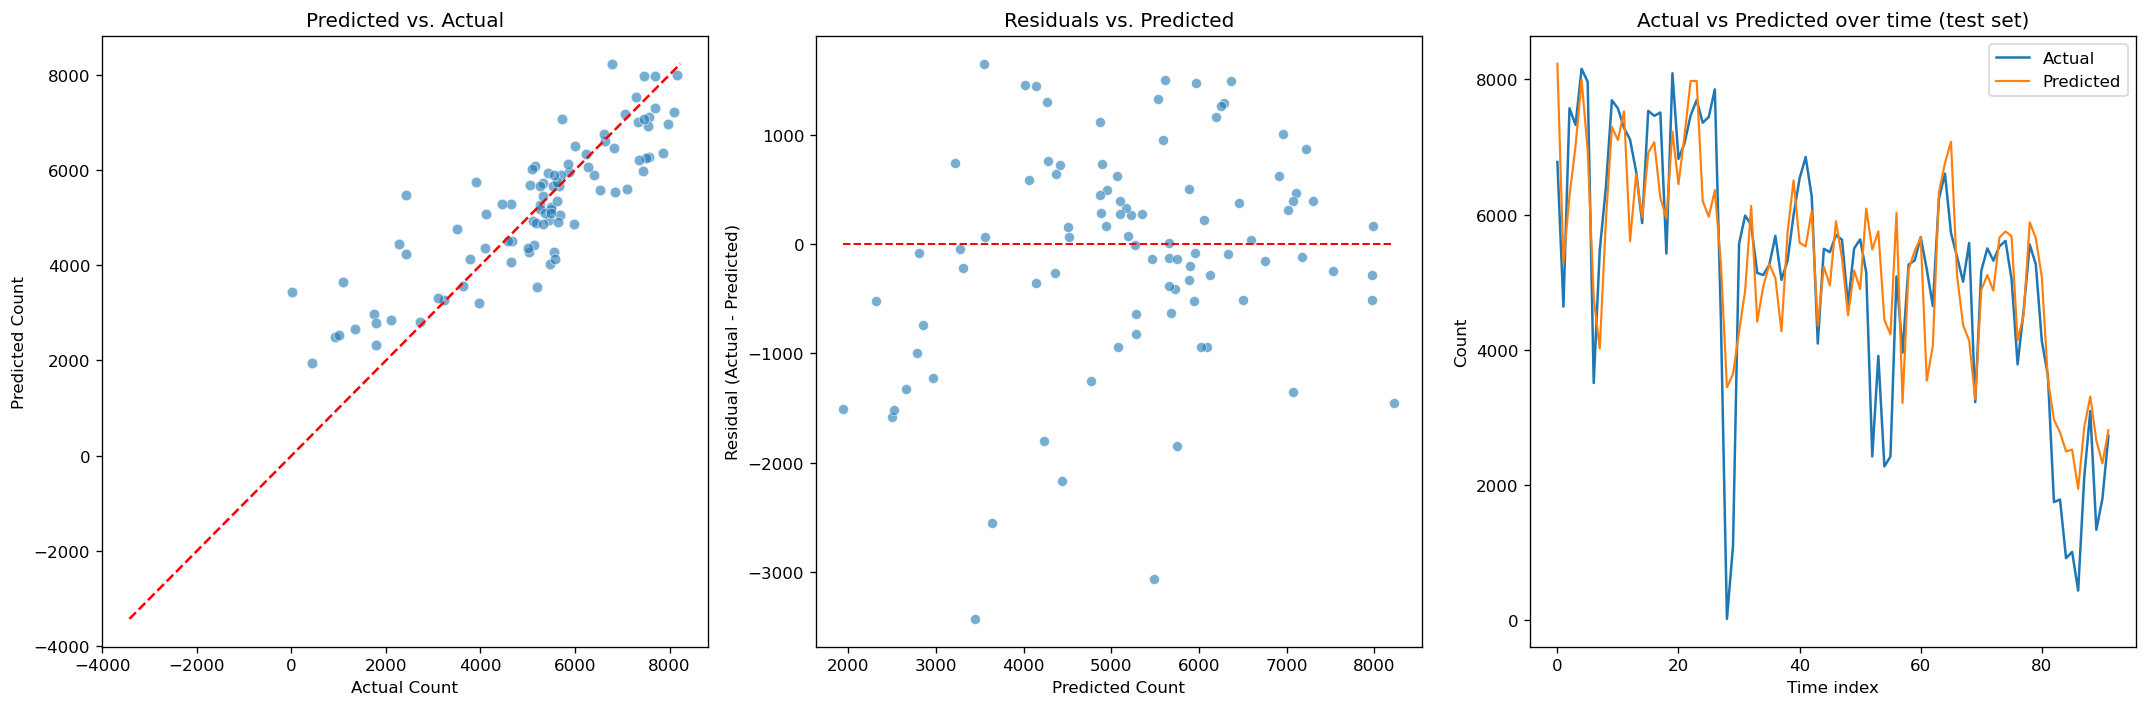

In [ ]:
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
results['Residuals'] = results['Actual'] - results['Predicted']


f, ax = plt.subplots(1,3, figsize=(18,6))

sns.scatterplot(data=results, x="Actual", y="Predicted", alpha=.6, s=40, ax=ax[0])
sns.lineplot(x=[results.min().min(), results.max().max()],
             y=[results.min().min(), results.max().max()],
             color='red', linestyle='--', ax=ax[0])
ax[0].set_title('Predicted vs. Actual')
ax[0].set_xlabel("Actual Count")
ax[0].set_ylabel("Predicted Count")

sns.scatterplot(data=results, x='Predicted', y="Residuals", alpha=.6, ax=ax[1])   
sns.lineplot(x=[results["Predicted"].min(), results["Predicted"].max()], y=[0,0], color='red', linestyle='--', linewidth=1.2, ax=ax[1])
ax[1].set_title('Residuals vs. Predicted')
ax[1].set_xlabel("Predicted Count")
ax[1].set_ylabel("Residual (Actual - Predicted)")


sns.lineplot(x=range(len(y_test)), y=y_test, label='Actual', linewidth=1.5, ax=ax[2])
sns.lineplot(x=range(len(y_test)), y=y_pred, label='Predicted', linewidth=1.3, ax=ax[2])
ax[2].set_title('Actual vs Predicted over time (test set)')
ax[2].set_xlabel('Time index')
ax[2].set_ylabel('Count')


ax[2].legend()
plt.tight_layout()
plt.show()

## Baseline modell értékelése

Train/Test felosztás: A vágás dátuma: **2012-10-01** (train: 2011-01-01–2012-09-30, test: 2012-10-01–2012-12-31).  
Metrikák (test):
- RMSE: 1010.31
- MAE:  756.38
- sMAPE:  20.35%
- R2:   0.723

Megjegyzés: A baseline a fő szezonális mintát eltalálja, de **az alacsony forgalmú napokat hajlamos felülbecsülni** (alsó negyedben pozitív bias).


## 2. Finomított Pipeline – rövid bevezető

### SHAP-alapú finomítás
A SHAP elemzés segítségével megnéztem, mely jellemzők járulnak hozzá leginkább az előrejelzéshez.  
A kevésbé hasznos, redundáns vagy negatív hatású változókat eltávolítottam (pl. `temp_sq`), mert nem növelték a teljesítményt.  

A legerősebb hatású jellemzők a hőmérséklethez (`temp`, `atemp`) és az időbeli ciklikussághoz (`sin_mnth`, `cos_mnth`, `sin_wd`, `cos_wd`) kapcsolódnak, így ezek maradtak a modellben.  
Az `is_weekend` változó megtartása is indokolt volt, mert a kereslet hétvégenként szignifikánsan eltér a hétköznapitól.


**A baseline eredményei alapján** a cél a **kis értékek felülbecslésének csökkentése** és az **általánosítás javítása** volt.  
A finomított verzióban szűkítettem a jellemzők körét (SHAP alapján), megtartottam a legerősebb prediktorokat és a ciklikus időjellemzőket, valamint óvatosabb boosting beállításokat alkalmaztam (`max_depth`, `min_samples_leaf`, `learning_rate`).  
Az egész folyamat továbbra is **Pipeline**-ban fut (FE_Refined → ColumnTransformer → HGBR).


In [46]:
# piecewise shrink
def transform_low(yhat, knee, alpha=0.15):
    s = np.clip((knee-yhat) / knee, 0, 1)
    return yhat * (1 - alpha * s)

In [ ]:
def fe_refined(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['sin_wd']   = np.sin(2*np.pi*df['weekday']/7)
    df['cos_wd']   = np.cos(2*np.pi*df['weekday']/7)
    df['sin_mnth'] = np.sin(2*np.pi*df['mnth']/12)
    df['cos_mnth'] = np.cos(2*np.pi*df['mnth']/12)

    df['temp_hum']  = df['temp'] * df['hum']
    df['temp_wind'] = df['temp'] * df['windspeed']
        
    # df['windspeed'] = np.clip(df['windspeed'], 0, 0.8)
    return df.drop(columns=['weekday', 'mnth'])


cat_cols = ['season','yr','workingday','weathersit']


model = HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        max_depth=6,
        min_samples_leaf=96,
        learning_rate=0.035,
        max_iter=5450,
        l2_regularization=0.0022,
        )


pipe_refined = Pipeline([
    ('fe', FunctionTransformer(fe_refined, validate=False)),    
    ('prep', ColumnTransformer([
        ('drop_holiday', 'drop', ['holiday']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')),
    ('model', model)
])

In [54]:
split_day = '2012-10-01'
train = df_daily[df_daily['dteday'] <  split_day].copy()
test  = df_daily[df_daily['dteday'] >= split_day].copy()

keep_cols = [
    'temp', 
    'atemp',       
    'hum',         
    'windspeed',   
    'season',      
    'weathersit',  
    'yr',          
    'workingday',  
    'weekday',
    'mnth',
    'holiday',
]

TARGET = 'cnt'

X_train = train[keep_cols].copy()
y_train = train[TARGET].copy()
X_test  = test[keep_cols].copy()
y_test  = test[TARGET].copy()

pipe_refined.fit(X_train, y_train)
y_pred = pipe_refined.predict(X_test)


knee = np.percentile(y_train, 30)
y_pred_adj = transform_low(y_pred, knee, alpha=0.2)

In [55]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_adj))
mae  = mean_absolute_error(y_test, y_pred_adj)
r2   = r2_score(y_test, y_pred_adj)
sMAPE = smape(y_test, y_pred_adj)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"sMAPE:  {sMAPE:.2f}%")
print(f"R2:   {r2:.3f}")

RMSE: 929.44
MAE:  692.07
sMAPE:  19.12%
R2:   0.766


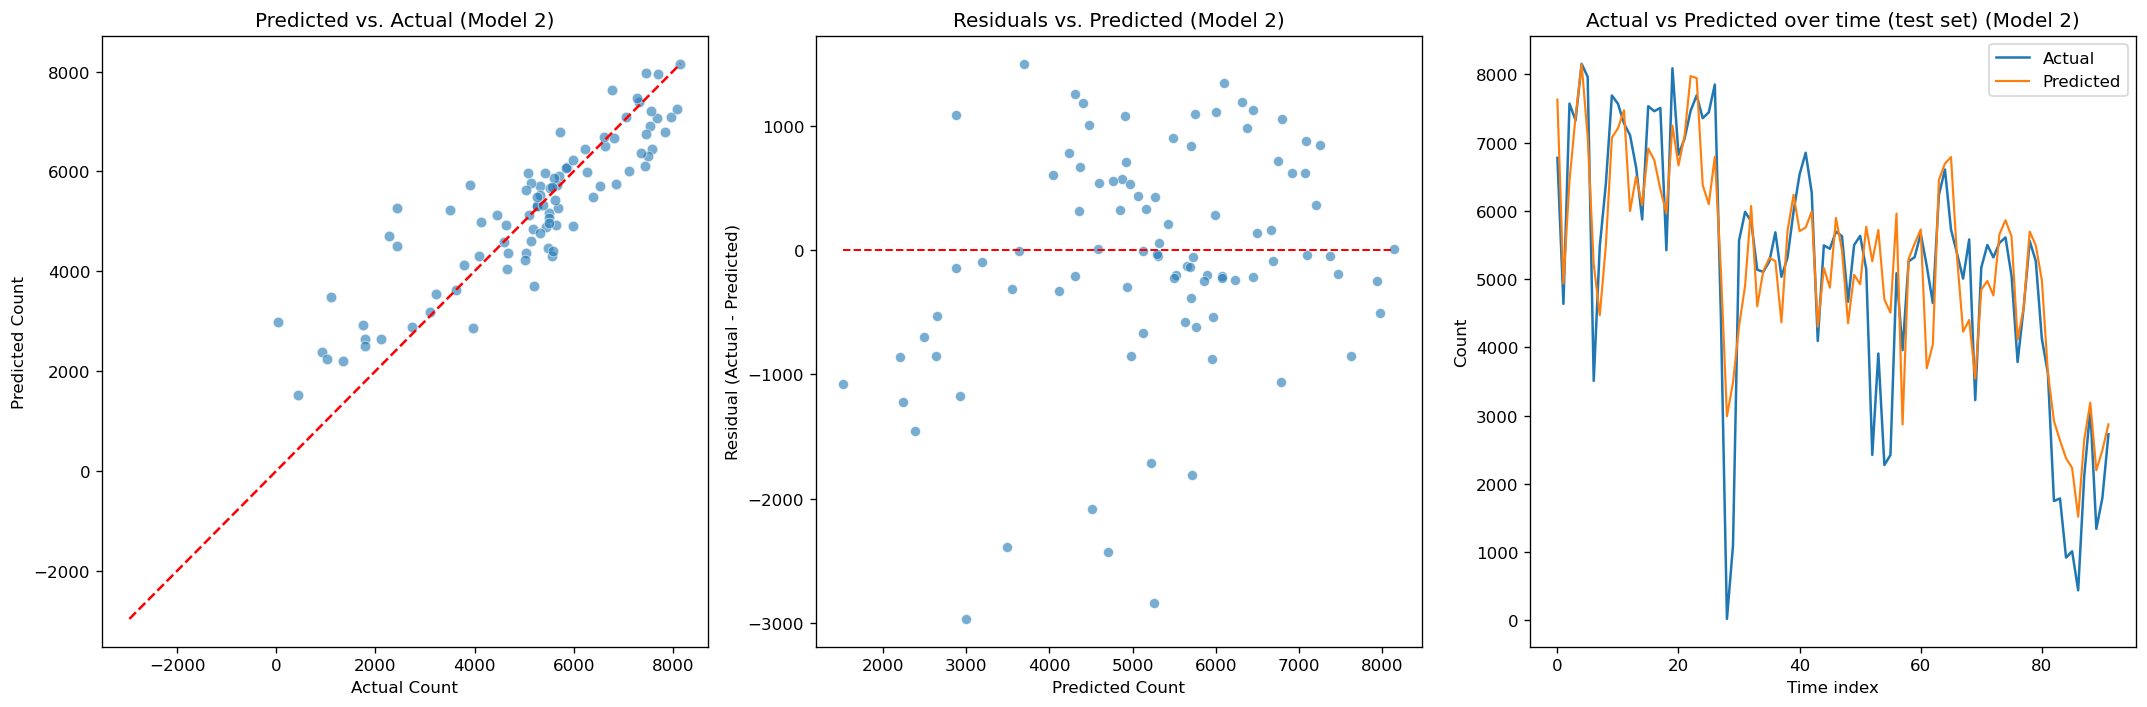

In [56]:
results_refined = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_adj})
results_refined['Residuals'] = results_refined['Actual'] - results_refined['Predicted']


f, ax = plt.subplots(1,3, figsize=(18,6))

sns.scatterplot(data=results_refined, x="Actual", y="Predicted", alpha=.6, s=40, ax=ax[0])
sns.lineplot(x=[results_refined.min().min(), results_refined.max().max()],
             y=[results_refined.min().min(), results_refined.max().max()],
             color='red', linestyle='--', ax=ax[0])
ax[0].set_title('Predicted vs. Actual (Model 2)')
ax[0].set_xlabel("Actual Count")
ax[0].set_ylabel("Predicted Count")

sns.scatterplot(data=results_refined, x='Predicted', y="Residuals", alpha=.6, ax=ax[1])   
sns.lineplot(x=[results_refined["Predicted"].min(), results_refined["Predicted"].max()], y=[0,0], color='red', linestyle='--', linewidth=1.2, ax=ax[1])
ax[1].set_title('Residuals vs. Predicted (Model 2)')
ax[1].set_xlabel("Predicted Count")
ax[1].set_ylabel("Residual (Actual - Predicted)")


sns.lineplot(x=range(len(y_test)), y=y_test, label='Actual', linewidth=1.5, ax=ax[2])
sns.lineplot(x=range(len(y_test)), y=y_pred_adj, label='Predicted', linewidth=1.3, ax=ax[2]) # type: ignore
ax[2].set_title('Actual vs Predicted over time (test set) (Model 2)')
ax[2].set_xlabel('Time index')
ax[2].set_ylabel('Count')


ax[2].legend()
plt.tight_layout()
plt.show()

## Refined modell értékelése

A második modell a baseline finomított verziója: SHAP-alapú jellemző-szűkítéssel, mérsékeltebb tanulási rátával és kiegyensúlyozottabb paraméterekkel.  
Célja az alsó értéktartomány felülibecslésének csökkentése, az általánosítás javítása, valamint egy utólagos **post-hoc piecewise shrink** leképezés bevezetése a predikciók finomhangolására.

A piecewise-shrink módszer egy egyszerű, egytöréspontos lineáris korrekció, amely az alsó tartománzban ( ~ 0–4000 értéktartomány) csökkenti a predikciók meredekségét, ezzel enyhíti a felmerülő pozitív bias-t.  
A megközelítés hasonló a **post-hoc calibration** technikákhoz, például az *isotonic regression* vagy a *quantile mapping* elvéhez, ahol a modell kimeneteit szakaszos (piecewise) függvénnyel illesztik a megfigyelésekhez.

### Teszt metrikák:

| Metrika | Érték |
|:--------|------:|
| **RMSE** | **929.44** |
| **MAE** | **692.07** |
| **sMAPE** | **19.12 %** |
| **R2** | **0.766** |

---

### Értékelés:

- A validációs hibák (RMSE, MAE) a baseline-hoz képest csökkentek, a predikciók időben stabilabbak.  
- Az alacsony értéktartományban (0–4000) megfigyelhető korábbi **felülibecslés** a piecewise-shrink korrekcióval mérséklődött, míg a magasabb tartományban (6000–8000) enyhe alulbecslés maradt.  
- A reziduumok eloszlása közel véletlenszerű, nem mutat szisztematikus mintázatot, ebből következthető, hogy a hibák inkább zajjellegűek.  

Összességében a frissített modell stabilabb, jobban általánosít, és a post-hoc korrekció révén kiegyensúlyozottabb hibaprofilt mutat, mint a baseline verzió.


## Következtetések és következő lépések

A finomhangolt modell némileg javított a baseline teljesítményén:
- sMAPE: **20.64% → 19.12%**
- RMSE: **1033.45 → 929.44**
- R2: **0.710 → 0.766**

A legnagyobb különbség az **alsó forgalmi tartomány** jobb illesztésében látható.

**Következő lépések:**
- [ ] Decilis szintű hibák részletes elemzése (`pd.qcut` alapú riport).  
- [ ] Idősoros cross-validation (`TimeSeriesSplit`) a paraméterek stabilabb finomítására.  
- [ ] Kvantil-regressziós keverék kipróbálása a kicsi napokra célzottan.  
- [ ] SHAP-alapú vizualizáció integrálása a pipeline-ba.
